# Machine Unlearning + Noise Generator

This is a copy of the original `Machine Unlearning.ipynb` notebook, with the key difference of using a different way of generating the noise.

In [1]:
# import required libraries
import numpy as np
import tarfile
import os
import math

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.models import resnet18


train_new_one = False
# torch.manual_seed(100)
# After I optimize the Hyperparameters, I want to calculate at least 30 models, to chech the average performance
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:0'

## Helper Functions

In [2]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def training_step(model, batch):
    images, labels = batch
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    out = model(images)                  
    loss = F.cross_entropy(out, labels) 
    return loss

def validation_step(model, batch):
    images, labels = batch
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    out = model(images)                    
    loss = F.cross_entropy(out, labels)   
    acc = accuracy(out, labels)
    return {'Loss': loss.detach(), 'Acc': acc}

def validation_epoch_end(model, outputs):
    batch_losses = [x['Loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   
    batch_accs = [x['Acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      
    return {'Loss': epoch_loss.item(), 'Acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['Loss'], result['Acc']))
    
def distance(model,model0):
    distance=0
    normalization=0
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        space='  ' if 'bias' in k else ''
        current_dist=(p.data0-p0.data0).pow(2).sum().item()
        current_norm=p.data0.pow(2).sum().item()
        distance+=current_dist
        normalization+=current_norm
    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

In [3]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(model, outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    for epoch in range(epochs): 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model, epoch, result)
        history.append(result)
        sched.step(result['Loss'])
    return history

## Train/Load the Model

### load the dataset

In [4]:
# Dowload the dataset
if os.path.exists("data/cifar10"):
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
    download_url(dataset_url, '.')

    # Extract from archive
    with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='./data')
        
    # Look into the data directory
    data_dir = './data/cifar10'
    print(os.listdir(data_dir))
    classes = os.listdir(data_dir + "/train")
    print(classes)

Using downloaded and verified file: ./cifar10.tgz


/tmp/ipykernel_14598/3544667939.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path='./data')


['test', 'train']
['bird', 'deer', 'horse', 'automobile', 'frog', 'airplane', 'truck', 'cat', 'dog', 'ship']


In [5]:
transform_train = tt.Compose([
    tt.ToTensor(),
    tt.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = tt.Compose([
    tt.ToTensor(),
    tt.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
train_ds = ImageFolder(data_dir+'/train', transform_train)
valid_ds = ImageFolder(data_dir+'/test', transform_test)

In [7]:
batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

### Train and save the model

In [8]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
model = resnet18(num_classes = 10).to(DEVICE)

epochs = 40
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [9]:
%%time
if os.exists("ResNET18_CIFAR10_ALL_CLASSES.pt"):
    history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)

    torch.save(model.state_dict(), "ResNET18_CIFAR10_ALL_CLASSES.pt")

AttributeError: module 'os' has no attribute 'exists'

### Testing the Model

In [10]:
if train_new_one:
    model.load_state_dict(torch.load("ResNET18_CIFAR10_ALL_CLASSES.pt", map_location=DEVICE))
    history = [evaluate(model, valid_dl)]
    history

## Unlearning

___

Originally used:

In [11]:
# # defining the noise structure
# class Noise(nn.Module):
#     def __init__(self, *dim):
#         super().__init__()
#         self.noise = torch.nn.Parameter(torch.randn(*dim), requires_grad = True)
        
#     def forward(self):
#         return self.noise

Trying a different approach:

In [12]:
class NoiseGenerator(nn.Module):
    """
    A neural network module for generating noise patterns
    through a series of fully connected layers.
    """

    def __init__(
            self, 
            dim_out: list,
            dim_hidden: list = [1000],
            dim_start: int = 100,
            ):
        """
        Initialize the NoiseGenerator.

        Parameters:
            dim_out (list): The output dimensions for the generated noise.
            dim_hidden (list): The dimensions of hidden layers, defaults to [1000].
            dim_start (int): The initial dimension of random noise, defaults to 100.
        """
        super().__init__()
        self.dim = dim_out
        self.start_dims = dim_start  # Initial dimension of random noise

        # Define fully connected layers
        self.layers = {}
        self.layers["l1"] = nn.Linear(self.start_dims, dim_hidden[0])
        last = dim_hidden[0]
        for idx in range(len(dim_hidden)-1):
            self.layers[f"l{idx+2}"] = nn.Linear(dim_hidden[idx], dim_hidden[idx+1])
            last = dim_hidden[idx+1]

        # Define output layer
        self.f_out = nn.Linear(last, math.prod(self.dim))        

    def forward(self):
        """
        Forward pass to transform random noise into structured output.

        Returns:
            torch.Tensor: The reshaped tensor with specified output dimensions.
        """
        # Generate random starting noise
        x = torch.randn(self.start_dims)
        x = x.flatten()

        # Transform noise into learnable patterns
        for layer in self.layers.keys():
            x = self.layers[layer](x)
            x = torch.relu(x)

        # Apply output layer
        x = self.f_out(x)

        # Reshape tensor to the specified dimensions
        reshaped_tensor = x.view(self.dim)
        return reshaped_tensor

___

In [13]:
# list of all classes
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# classes which are required to un-learn
classes_to_forget = [0, 2]

In [14]:
# classwise list of samples
num_classes = 10
classwise_train = {}
for i in range(num_classes):
    classwise_train[i] = []

for img, label in train_ds:
    classwise_train[label].append((img, label))
    
classwise_test = {}
for i in range(num_classes):
    classwise_test[i] = []

for img, label in valid_ds:
    classwise_test[label].append((img, label))

In [15]:
# getting some samples from retain classes
num_samples_per_class = 1000

retain_samples = []
for i in range(len(classes)):
    if classes[i] not in classes_to_forget:
        retain_samples += classwise_train[i][:num_samples_per_class]
        

In [16]:
# retain validation set
retain_valid = []
for cls in range(num_classes):
    if cls not in classes_to_forget:
        for img, label in classwise_test[cls]:
            retain_valid.append((img, label))
            
# forget validation set
forget_valid = []
for cls in range(num_classes):
    if cls in classes_to_forget:
        for img, label in classwise_test[cls]:
            forget_valid.append((img, label))
            
forget_valid_dl = DataLoader(forget_valid, batch_size, num_workers=3, pin_memory=True)
retain_valid_dl = DataLoader(retain_valid, batch_size*2, num_workers=3, pin_memory=True)

### Training the Noise

In [17]:
# loading the model
model = resnet18(num_classes = 10).to(DEVICE)
model.load_state_dict(torch.load("ResNET18_CIFAR10_ALL_CLASSES.pt", map_location=DEVICE))

/tmp/ipykernel_14598/1124881384.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ResNET18_CIFAR10_ALL_CLASSES.pt", map_location=DEVICE))

<All keys matched successfully>

In [18]:
%%time

if train_new_one:
    noises = {}
    for cls in classes_to_forget:
        print("Optiming loss for class {}".format(cls))
        noises[cls] = Noise(batch_size, 3, 32, 32)
        opt = torch.optim.Adam(noises[cls].parameters(), lr = 0.1)

        num_epochs = 5
        num_steps = 8
        class_label = cls
        for epoch in range(num_epochs):
            total_loss = []
            for batch in range(num_steps):
                inputs = noises[cls]()
                labels = torch.zeros(batch_size)+class_label
                outputs = model(inputs)
                loss = -F.cross_entropy(outputs, labels.long()) + 0.1*torch.mean(torch.sum(torch.square(inputs), [1, 2, 3]))
                opt.zero_grad()
                loss.backward()
                opt.step()
                total_loss.append(loss.cpu().detach().numpy())
            print("Loss: {}".format(np.mean(total_loss)))

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.25 μs


## Impair Step

In [19]:
%%time

batch_size = 256
noisy_data = []
num_batches = 20
class_num = 0

for cls in classes_to_forget:
    for i in range(num_batches):
        batch = noises[cls]().cpu().detach()
        for i in range(batch[0].size(0)):
            noisy_data.append((batch[i], torch.tensor(class_num)))

other_samples = []
for i in range(len(retain_samples)):
    other_samples.append((retain_samples[i][0].cpu(), torch.tensor(retain_samples[i][1])))
noisy_data += other_samples
noisy_loader = torch.utils.data.DataLoader(noisy_data, batch_size=256, shuffle = True)


if train_new_one:
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.02)

    for epoch in range(1):  
        model.train(True)
        running_loss = 0.0
        running_acc = 0
        for i, data in enumerate(noisy_loader):
            inputs, labels = data
            inputs, labels = inputs,torch.tensor(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * inputs.size(0)
            out = torch.argmax(outputs.detach(),dim=1)
            assert out.shape==labels.shape
            running_acc += (labels==out).sum().item()
        print(f"Train loss {epoch+1}: {running_loss/len(train_ds)},Train Acc:{running_acc*100/len(train_ds)}%")

NameError: name 'noises' is not defined

### Performance after Impair Step

In [20]:
if train_new_one:
    print("Performance of Standard Forget Model on Forget Class")
    history = [evaluate(model, forget_valid_dl)]
    print("Accuracy: {}".format(history[0]["Acc"]*100))
    print("Loss: {}".format(history[0]["Loss"]))

    print("Performance of Standard Forget Model on Retain Class")
    history = [evaluate(model, retain_valid_dl)]
    print("Accuracy: {}".format(history[0]["Acc"]*100))
    print("Loss: {}".format(history[0]["Loss"]))

## Repair Step

In [21]:
%%time

heal_loader = torch.utils.data.DataLoader(other_samples, batch_size=256, shuffle = True)
if train_new_one:
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)


    for epoch in range(1):  
        model.train(True)
        running_loss = 0.0
        running_acc = 0
        for i, data in enumerate(heal_loader):
            inputs, labels = data
            inputs, labels = inputs,torch.tensor(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * inputs.size(0)
            out = torch.argmax(outputs.detach(),dim=1)
            assert out.shape==labels.shape
            running_acc += (labels==out).sum().item()
        print(f"Train loss {epoch+1}: {running_loss/len(train_ds)},Train Acc:{running_acc*100/len(train_ds)}%")

NameError: name 'other_samples' is not defined

### Performance after Repair Step

In [22]:
if train_new_one:
    print("Performance of Standard Forget Model on Forget Class")
    history = [evaluate(model, forget_valid_dl)]
    print("Accuracy: {}".format(history[0]["Acc"]*100))
    print("Loss: {}".format(history[0]["Loss"]))

    print("Performance of Standard Forget Model on Retain Class")
    history = [evaluate(model, retain_valid_dl)]
    print("Accuracy: {}".format(history[0]["Acc"]*100))
    print("Loss: {}".format(history[0]["Loss"]))

In [23]:
from typing import Dict

def load_models_dict(path: str="data/new/models") -> Dict[str, torch.nn.Module]:
    de = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = resnet18(num_classes = 10).to(de)
    
    # load all the models
    md = {}
    for list in os.listdir(path):
        
        model.load_state_dict(torch.load(f=os.path.join(path, list), map_location=DEVICE, weights_only=True))
        model.eval()
        md[len(md)] = model

    return md

In [24]:
from src.fyemu_tunable import main

if True:
    model = main(
        new_baseline=False
    )
    
    if not os.path.exists("data/new/models"):
        os.makedirs("data/new/models")
    n = len(os.listdir("data/new/models"))
    torch.save(model.state_dict(), f"data/new/models/ResNET18_CIFAR10_UN_{n}.pt")

[{'Loss': 1.3517661094665527, 'Acc': 0.7792420387268066}]
Performance of Standard Forget Model on Forget Class
Accuracy: 0.0
Loss: 9.188455581665039
Performance of Standard Forget Model on Retain Class
Accuracy: 61.83837652206421
Loss: 1.075740098953247
Performance of Standard Forget Model on Forget Class
Accuracy: 0.0
Loss: 9.611581802368164
Performance of Standard Forget Model on Retain Class
Accuracy: 69.4384753704071
Loss: 0.8779372572898865


___
## Evaluate multiple models

In [25]:
from PIL import Image
import tarfile
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# Firstly, all the data
class SubData(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        path, label = self.data[idx]

        img = Image.open(f"{path}").convert('RGB')
        img = self.transform(img)
        label = torch.tensor(label)
        return img.to(self.device), label.to(self.device)

data_dir = f'data{os.sep}cifar10'
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# classes which are required to un-learn
classes_to_forget = [0, 2]

transform_test = tt.Compose([
    tt.ToTensor(),
    tt.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_train = tt.Compose([
    tt.ToTensor(),
    tt.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [26]:
valid_all_ds = ImageFolder(data_dir+f'{os.sep}test', transform_test)
valid_all_dl = DataLoader(valid_all_ds, 256,)

train_all_ds = ImageFolder(data_dir+f'{os.sep}train', transform_train)
train_all_dl = DataLoader(train_all_ds, 256,)

rt_tr = {}
for t, l in train_all_ds.imgs:
    if l not in classes_to_forget:
        rt_tr[len(rt_tr)] = (t, l)
rt_vl = {}
for t, l in valid_all_ds.imgs:
    if l not in classes_to_forget:
        rt_vl[len(rt_vl)] = (t, l)

train_retain_ds = SubData(rt_tr, transform_train)
valid_retain_ds = SubData(rt_vl, transform_test)

train_retain_dl = DataLoader(train_retain_ds, 256, shuffle=True)
valid_retain_dl = DataLoader(valid_retain_ds, 256*2)

rt_tr = {}
for t, l in train_all_ds.imgs:
    if l in classes_to_forget:
        rt_tr[len(rt_tr)] = (t, l)
rt_vl = {}
for t, l in valid_all_ds.imgs:
    if l in classes_to_forget:
        rt_vl[len(rt_vl)] = (t, l)

train_forget_ds = SubData(rt_tr, transform_train)
valid_forget_ds = SubData(rt_vl, transform_test)

train_forget_dl = DataLoader(train_forget_ds, 256, shuffle=True)
valid_forget_dl = DataLoader(train_forget_ds, 256*2)

loaders = {
    0: train_all_dl,
    1: valid_all_dl,
    2: train_retain_dl,
    3: valid_retain_dl,
    4: train_forget_dl,
    5: valid_forget_dl,
}

In [27]:
import src.metrics
from src.fyemu_tunable import evaluate
paper_ms    = load_models_dict(path="data/paper/models")
gemu_ms     = load_models_dict(path="data/new/models")

exact_ms    = load_models_dict(path="data/retrain/models")

In [28]:
def run(model, loaders):
    results = {}
    for name, loader in loaders.items():
        results[name] = evaluate(model.to(DEVICE), loader)

    return results
run(exact_ms[0], loaders)

{0: {'Loss': 2.125023365020752, 'Acc': 0.8007015585899353},
 1: {'Loss': 3.0320842266082764, 'Acc': 0.643359363079071},
 2: {'Loss': 0.00032785828807391226, 'Acc': 1.0},
 3: {'Loss': 1.1749095916748047, 'Acc': 0.7978271245956421},
 4: {'Loss': 10.64272403717041, 'Acc': 0.0},
 5: {'Loss': 10.659263610839844, 'Acc': 0.0}}

In [29]:
kl_exact_to_fyemu = {key: src.metrics.kl_divergence_between_models(exact_ms[0], paper_ms[0], loader) for key, loader in loaders.items()}

In [30]:
kl_exact_to_fyemu

{0: 3.001258940112834,
 1: 2.3969006985425954,
 2: 2.9558742061542094,
 3: 2.253737926483154,
 4: 3.1943638205528258,
 5: 3.2036361098289494}

In [31]:
kl_exact_to_gemu= {key: src.metrics.kl_divergence_between_models(exact_ms[0], gemu_ms[0], loader) for key, loader in loaders.items()}

In [32]:
kl_exact_to_gemu

{0: 3.1400943976275797,
 1: 2.5975292026996617,
 2: 3.17433748579329,
 3: 2.5042692273855214,
 4: 3.0013855218887335,
 5: 3.023870861530304}

In [33]:
import matplotlib.pyplot as plt
from typing import Dict, List, Literal

def create_boxplots(score_lists1: Dict[str, List[float]], score_lists2: Dict[str, List[float]], score_lists3: Dict[str, List[float]], title: str = 'Box Plot of Accuracy Scores for Different Models', evaluation: Literal["Accuracy", "Loss"] = "Accuracy") -> None:
    """Create a box plot of accuracy scores for each parsed list in the diconary."""

    # Prepare data for the box plot
    data1 = [sum(scores)/len(scores) for scores in score_lists1.values()]
    data2 = [sum(scores)/len(scores) for scores in score_lists2.values()]
    data3 = [sum(scores)/len(scores) for scores in score_lists3.values()]
    labels = list(score_lists1.keys())
    X_axis = (np.arange(len(labels)))

    # Create the box plot
    plt.figure(figsize=(10, 6))
    plt.bar(x=X_axis-0.3   , height=data1, width=0.3, color="blue", label="Baseline")
    plt.bar(x=X_axis        , height=data2, width=0.3, color="red", label="FYEMU")
    plt.bar(x=X_axis+0.3   , height=data3, width=0.3, color="orange", label="GEMU")

    # Add labels and title
    plt.xticks(X_axis, labels)
    plt.xlabel('Subsets')
    plt.ylabel(f'{evaluation} Score')
    plt.ylim(0, 1.0)
    plt.title(title)
    plt.legend()

    # Display the plot
    plt.show()

### Accuracy Per Class

In [34]:
from PIL import Image
import tarfile
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

data_classes = {}
for c in classes:
    data_classes[c] = {}
    for t, l in valid_all_ds.imgs:
        if l == c:
            data_classes[c][len(data_classes[c])] = (t, l)

data_dl_classes = {c: DataLoader(SubData(data_classes[c], transform_test), 256) for c in classes}

In [35]:
class_accs_paper = {c: [] for c in classes}
for idx, model in paper_ms.items():
    model.eval()
    accs = run(model, data_dl_classes)
    for c, acc in accs.items():
        class_accs_paper[c].append(acc["Acc"])

In [36]:
class_accs_gemu = {c: [] for c in classes}
for idx, model in gemu_ms.items():
    model.eval()
    accs = run(model, data_dl_classes)
    for c, acc in accs.items():
        class_accs_gemu[c].append(acc["Acc"])

In [37]:
class_accs_exact = {c: [] for c in classes}
for idx, model in exact_ms.items():
    model.eval()
    accs = run(model, data_dl_classes)
    for c, acc in accs.items():
        class_accs_exact[c].append(acc["Acc"])

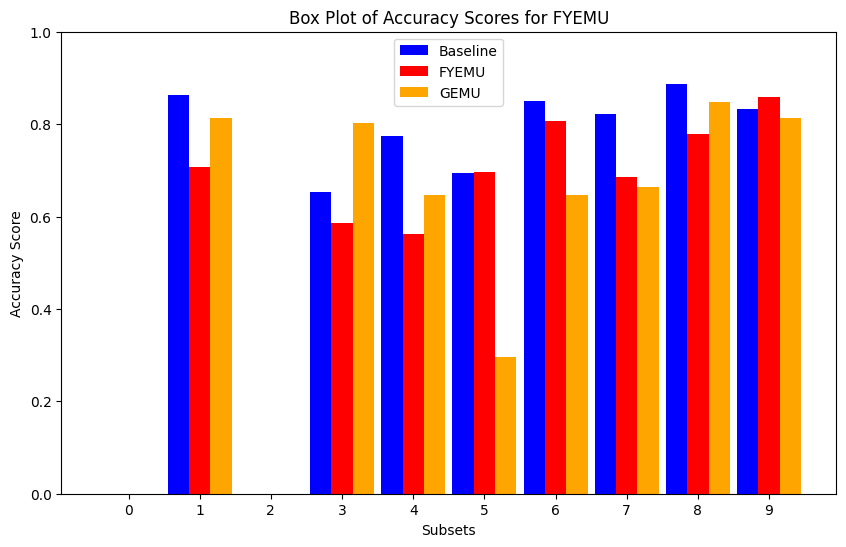

In [38]:
create_boxplots(class_accs_exact, class_accs_paper, class_accs_gemu, "Box Plot of Accuracy Scores for FYEMU", "Accuracy")

In [39]:
# Delta Acc

sum([np.absolute(sum(i)/len(i)-(sum(j)/len(j))) for i, j in zip(class_accs_exact.values(), class_accs_paper.values())])

np.float64(0.7518858313560486)

In [40]:

sum([np.absolute(sum(i)/len(i)-(sum(j)/len(j))) for i, j in zip(class_accs_exact.values(), class_accs_gemu.values())])

np.float64(1.151737630367279)